# Project Report: Combining and Analyzing Global Datasets
---
## 1. Wrangling Details
### 1.1 Dependencies and Imports

**Description**
- Install necessary Python packages and import libraries required for the analysis.

**Steps**
- Install the linearmodels package for panel data analysis.
- Import libraries like pandas, numpy, sklearn.preprocessing, and statsmodels.

In [ ]:
pip install linearmodels

In [35]:
# Greenhouse dataset: Contains emissions data per country and year
# Source: https://data-explorer.oecd.org/vis?df[ds]=DisseminateFinalDMZ&df[id]=DSD_AIR_GHG%40DF_AIR_GHG&df[ag]=OECD.ENV.EPI&dq=.A.GHG._T.KG_CO2E_PS&pd=2014%2C&to[TIME_PERIOD]=false&ly[cl]=TIME_PERIOD&ly[rw]=REF_AREA&vw=tb
# Columns selected: "Reference area" (country), "TIME_PERIOD" (year), "OBS_VALUE" (emission values)

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects

## 1.2 Dataset 1: Greenhouse Gas Emissions
**Origin**
- Source: Organisation for Economic Co-operation and Development (OECD)
- Access: https://data-explorer.oecd.org/vis?df[ds]=DisseminateFinalDMZ&df[id]=DSD_AIR_GHG%40DF_AIR_GHG&df[ag]=OECD.ENV.EPI&dq=.A.GHG._T.KG_CO2E_PS&pd=2014%2C&to[TIME_PERIOD]=false&ly[cl]=TIME_PERIOD&ly[rw]=REF_AREA&vw=tb
- Purpose: This dataset was chosen to analyze greenhouse gas emissions per country and year, which is essential for understanding environmental impacts and the relationships with economic indicators.

### General Characteristics
***Format:*** CSV file

***Structure:*** 
- Columns: `Reference area` (Country), `TIME_PERIOD` (Year), `OBS_VALUE` (Emission Value)
- Rows: Over 1,000 entries
- Size: 1,000+ rows, 3 columns

**Initial Audit**
- Observations: Contains missing values in the OBS_VALUE column.
- Potential Problems: Some rows have incomplete records (e.g., missing emissions for certain years).

**Transformations**
- Renamed columns for consistency.
- Converted `Year` to an integer type.
- Dropped rows with missing values.

In [36]:
# Load Greenhouse dataset
greenhouse = pd.read_csv("greenhouse_csv.csv", usecols=["Reference area", "TIME_PERIOD", "OBS_VALUE"])


# Clean and prepare the Greenhouse dataset
greenhouse.rename(columns={
    "Reference area": "Country",
    "TIME_PERIOD": "Year",
    "OBS_VALUE": "Emission Value"
}, inplace=True)
# Sort Greenhouse dataset
greenhouse=greenhouse.sort_values(by=["Country", "Year"], ascending=[True, False]).reset_index(drop=True)

# Convert to integer
greenhouse["Year"] = greenhouse["Year"].astype(int)

# Remove rows with missing values
greenhouse_cleaned = greenhouse.dropna()
greenhouse_cleaned

,Country,Year,Emission Value
0,Argentina,2020,8.295901
1,Argentina,2019,7.343352
2,Argentina,2018,8.266537
3,Argentina,2017,8.367887
4,Argentina,2016,8.292151
...,...,...,...
548,United States,2017,20.182650
549,United States,2016,20.362140
550,United States,2015,21.005740
551,United States,2014,21.667150


## 1.3 Dataset 2: World Development Indicators (WDI)
**Origin**
- Source: The World Bank
- Access: World Development Indicators Dataset
- Purpose: Provides economic and environmental indicators essential for analyzing the relationships between economic development and greenhouse gas emissions.

**General Characteristics**
***Format:*** CSV file
***Structure:***
- Columns: include `Country Name`, `Time`, `GDP (US$)`, `Renewable Energy Consumption`, `Forest Area`, etc.
- Rows: Over 10,000 entries
- Size: 20+ columns × 10,000+ rows

**Initial Audit**
- Observations: Missing values in several columns.
- Potential Problems: Zero and negative values in GDP columns cause issues with logarithmic transformations.

**Transformations**
- Renamed columns for consistency.
- Dropped irrelevant columns like `Country Code` and `Time Code`.
- Converted GDP-related columns to numeric types and replaced zero/negative values with NaN.
- Added logarithmic transformations for GDP and GDP per capita.
- Dropped rows with missing values.

In [ ]:
# Load WDI dataset
wdi = pd.read_csv("wdi.csv", encoding="latin1", on_bad_lines="skip")[:-8]

# Rename columns for clarity
wdi.rename(columns={
    "Time": "Year",
    "Country Name": "Country",
    "Industry (including construction), value added (% of GDP) [NV.IND.TOTL.ZS]": "Industry Value Added (% of GDP)",
    "GDP (current US$) [NY.GDP.MKTP.CD]": "GDP (US$)",
    "GDP per capita (current US$) [NY.GDP.PCAP.CD]": "GDP per Capita (US$)",
    "Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]": "Renewable Energy Consumption (%)",
    "Forest area (% of land area) [AG.LND.FRST.ZS]": "Forest Area (%)"
}, inplace=True)

wdi['Country'] = wdi['Country'].replace({
    'China': "China (People's Republic of)",
    'Korea, Rep.': 'Korea',
    'Russian Federation': 'Russia',
    'Turkiye': 'Türkiye'
})

# Drop unnecessary columns
wdi.drop(columns=["Time Code", "Country Code"], inplace=True, errors='ignore')

# Convert "Year" to integer and ensure all numeric columns are proper types
wdi["Year"] = wdi["Year"].astype(int)


# Add log-transformed columns for GDP values
wdi["GDP (US$)"] = pd.to_numeric(wdi["GDP (US$)"], errors="coerce")
wdi["GDP per Capita (US$)"] = pd.to_numeric(wdi["GDP per Capita (US$)"], errors="coerce")

wdi["Log GDP (US$)"] = np.log(wdi["GDP (US$)"])
wdi["Log GDP per Capita (US$)"] = np.log(wdi["GDP per Capita (US$)"])

indicators_to_convert = [
    "Industry Value Added (% of GDP)",
    "GDP (US$)",
    "GDP per Capita (US$)",
    "Log GDP (US$)",
    "Log GDP per Capita (US$)",
    "Renewable Energy Consumption (%)",
    "Forest Area (%)"
]
for col in indicators_to_convert:
    wdi[col] = pd.to_numeric(wdi[col], errors="coerce")
    
# Remove rows with missing values
wdi_cleaned = wdi.dropna()
wdi_cleaned

,Year,Country,Industry Value Added (% of GDP),GDP (US$),GDP per Capita (US$),Renewable Energy Consumption (%),Forest Area (%),Log GDP (US$),Log GDP per Capita (US$)
0,2013,United Arab Emirates,54.203815,4.002185e+11,45729.607676,0.1,4.467756,26.715277,10.730501
1,2013,Afghanistan,20.444605,2.014642e+10,638.733181,16.9,1.852782,23.726292,6.459487
2,2013,Albania,23.061317,1.277622e+10,4413.063383,41.1,28.698558,23.270852,8.392324
3,2013,Algeria,39.743854,2.297014e+11,6044.674903,0.1,0.814866,26.160046,8.706933
5,2013,Andorra,10.618247,3.193513e+09,44747.753864,19.1,34.042553,21.884387,10.708797
...,...,...,...,...,...,...,...,...,...
2336,2021,Uzbekistan,31.490751,6.960061e+10,1993.424478,1.0,8.431805,24.966039,7.597609
2339,2021,Viet Nam,37.391519,3.664748e+11,3759.948329,24.2,46.961162,26.627195,8.232160
2341,2021,West Bank and Gaza,17.685129,1.810900e+10,3678.635657,15.4,1.682988,23.619675,8.210297
2343,2021,Zambia,41.831938,2.209642e+10,1134.713454,83.0,60.030150,23.818681,7.034135


1.4 Combining the Datasets
Steps to Combine

Key Fields: Country and Year were used as primary keys to merge the datasets.
Method: An inner join (how="inner") was performed to keep only matching entries in both datasets.
Transformations on Combined Dataset

Set Country and Year as a multi-index for panel data analysis.

In [ ]:
# Merge cleaned datasets
merged_data = pd.merge(
    greenhouse_cleaned, 
    wdi_cleaned, 
    on=["Country", "Year"], 
    how="inner"
)

# Set index for regression analysis
merged_data.set_index(["Country", "Year"], inplace=True)
merged_data

Emission Value  Industry Value Added (% of GDP)  \
Country       Year                                                    
Argentina     2020        8.295901                        22.408876   
              2019        7.343352                        23.157848   
              2018        8.266537                        23.719592   
              2017        8.367887                        21.782123   
              2016        8.292151                        22.054107   
...                            ...                              ...   
United States 2017       20.182650                        18.308744   
              2016       20.362140                        17.936872   
              2015       21.005740                        18.496713   
              2014       21.667150                        19.268434   
              2013       21.646720                        19.198890   

                       GDP (US$)  GDP per Capita (US$)  \
Country       Year                                       
Argentina     2020  3.857405e+11           8500.837939   
              2019  4.477547e+11           9963.674162   
              2018  5.248199e+11          11795.162745   
              2017  6.436284e+11          14613.035649   
              2016  5.575323e+11          12790.264140   
...                          ...                   ...   
United States 2017  1.961210e+13          60322.261424   
              2016  1.880491e+13          58206.614193   
              2015  1.829502e+13          57040.208214   
              2014  1.760814e+13          55304.315532   
              2013  1.688068e+13          53409.750777   

                    Renewable Energy Consumption (%)  Forest Area (%)  \
Country       Year                                                      
Argentina     2020                               9.8        10.440715   
              2019                              10.7        10.480179   
              2018                              10.5        10.520373   
              2017                              10.4        10.559837   
              2016                               9.4        10.600397   
...                                              ...              ...   
United States 2017                               9.7        33.866926   
              2016                               9.3        33.899723   
              2015                               8.9        33.899723   
              2014                               9.0        33.869659   
              2013                               8.9        33.839596   

                    Log GDP (US$)  Log GDP per Capita (US$)  
Country       Year                                           
Argentina     2020      26.678431                  9.047920  
              2019      26.827511                  9.206701  
              2018      26.986321                  9.375445  
              2017      27.190387                  9.589669  
              2016      27.046786                  9.456440  
...                           ...                       ...  
United States 2017      30.607168                 11.007456  
              2016      30.565139                 10.971754  
              2015      30.537650                 10.951512  
              2014      30.499382                 10.920606  
              2013      30.457191                 10.885749  

[454 rows x 8 columns]

In [39]:
# 按国家分组并补齐缺失值
#def fill_na_by_group(data, group_col, year_col, target_cols):
    #def fill_for_country(group):
        #group = group.sort_values(year_col).reset_index(drop=True)  # 按年份排序
        #for col in target_cols:
            #for i in range(len(group)):
                #if pd.isna(group.loc[i, col]):  # 如果当前值为NA
                    # 只使用当前行之前的数据的均值
                    #previous_data = group.loc[:i-1, col]  # 获取之前年份的列值
                    #mean_val = previous_data.mean(skipna=True)  # 计算均值
                    #group.loc[i, col] = mean_val  # 用均值填充当前NA
        #return group

    # 按国家分组并应用上述逻辑
    #return data.groupby(group_col, group_keys=False).apply(fill_for_country)

# 应用到 greenhouse 数据集
#greenhouse_filled = fill_na_by_group(greenhouse, "Country", "Year", ["Emission Value"])

# 应用到 WDI 数据集
#wdi_filled = fill_na_by_group(wdi, "Country", "Year", indicators_to_convert)

In [40]:
# Save the final dataset
merged_data.to_csv("combined_dataset.csv", index=False)

correlation matrix

                                  Industry Value Added (% of GDP)  \
Industry Value Added (% of GDP)                          1.000000   
Log GDP (US$)                                            0.038313   
Log GDP per Capita (US$)                                -0.181911   
Renewable Energy Consumption (%)                         0.048973   
Forest Area (%)                                          0.253654   

                                  Log GDP (US$)  Log GDP per Capita (US$)  \
Industry Value Added (% of GDP)        0.038313                 -0.181911   
Log GDP (US$)                          1.000000                  0.107672   
Log GDP per Capita (US$)               0.107672                  1.000000   
Renewable Energy Consumption (%)      -0.366489                  0.292649   
Forest Area (%)                        0.076921                 -0.035229   

                                  Renewable Energy Consumption (%)  \
Industry Value Added (% of GDP)                     

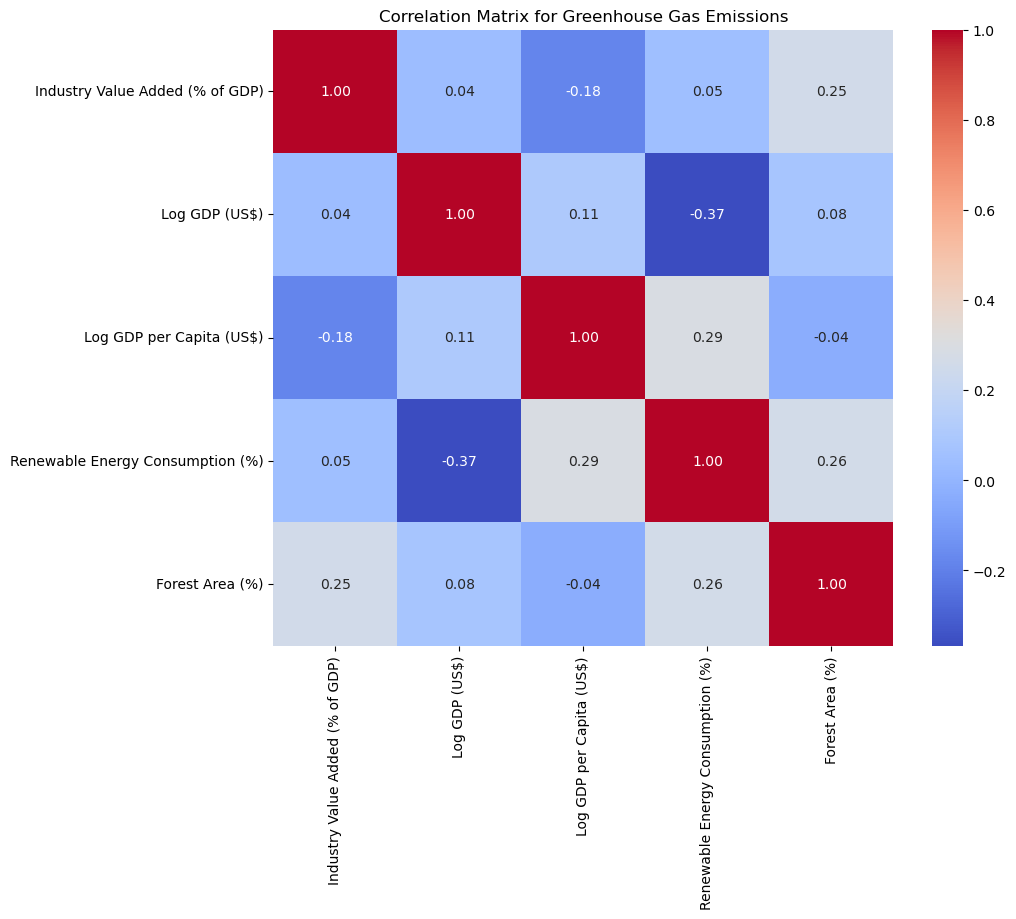

In [41]:
import pandas as pd

# 提取与温室气体排放相关的列
greenhouse_gases = merged_data[[
    "Industry Value Added (% of GDP)",
    "Log GDP (US$)",
    "Log GDP per Capita (US$)",
    "Renewable Energy Consumption (%)",
    "Forest Area (%)"
]]

# 将列转换为数值类型（如果尚未转换）
greenhouse_gases = greenhouse_gases.apply(pd.to_numeric, errors='coerce')

# 计算相关性矩阵
correlation_matrix = greenhouse_gases.corr()

# 输出相关性矩阵
print(correlation_matrix)

# 如果需要可视化相关性矩阵
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Greenhouse Gas Emissions")
plt.show()


固定效应分析

In [43]:
from linearmodels.panel import PanelOLS

# 定义变量
independent_vars = [
    "Industry Value Added (% of GDP)",
    "Log GDP (US$)",
    "Log GDP per Capita (US$)",
    "Renewable Energy Consumption (%)",
    "Forest Area (%)"
]
dependent_var = "Emission Value"


# 定义自变量和因变量
X = merged_data[independent_vars]
X = sm.add_constant(X)  # 添加常数项
y = merged_data[dependent_var]

# 创建固定效应模型
fixed_effects_model = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)

# 拟合模型
fixed_effects_results = fixed_effects_model.fit()
fixed_effects_results


Dep. Variable:,Emission Value,R-squared:,0.6173
Estimator:,PanelOLS,R-squared (Between):,-10.474
No. Observations:,454,R-squared (Within):,0.6173
Date:,"Fri, Nov 22 2024",R-squared (Overall):,-10.785
Time:,21:46:08,Log-likelihood,-288.26
Cov. Estimator:,Unadjusted,,
,,F-statistic:,127.12
Entities:,55,P-value,0.0000
Avg Obs:,8.2545,Distribution:,"F(5,394)"
Min Obs:,1.0000,,
Max Obs:,9.0000,F-statistic (robust):,127.12


固定效应随机效应选择

In [44]:
import numpy as np
from linearmodels.panel import PanelOLS, RandomEffects
from scipy.stats import chi2
# 随机效应模型
random_effects_model = RandomEffects(y, X)

# 拟合模型
random_effects_results = random_effects_model.fit()

# 输出结果
print("随机效应模型结果：")
print(random_effects_results.summary)



随机效应模型结果：
                        RandomEffects Estimation Summary                        
Dep. Variable:         Emission Value   R-squared:                        0.5202
Estimator:              RandomEffects   R-squared (Between):             -0.1003
No. Observations:                 454   R-squared (Within):               0.5647
Date:                Fri, Nov 22 2024   R-squared (Overall):             -0.2529
Time:                        21:46:19   Log-likelihood                   -355.73
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      97.135
Entities:                          55   P-value                           0.0000
Avg Obs:                       8.2545   Distribution:                   F(5,448)
Min Obs:                       1.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             96.932
                  

In [45]:
import numpy as np
from scipy.stats import chi2

# 提取系数和协方差矩阵
beta_fixed = fixed_effects_results.params
beta_random = random_effects_results.params
cov_fixed = fixed_effects_results.cov
cov_random = random_effects_results.cov

# Hausman 检验统计量
hausman_stat = (beta_fixed - beta_random).T @ np.linalg.inv(cov_fixed - cov_random) @ (beta_fixed - beta_random)

# 计算 p 值
p_value = 1 - chi2.cdf(hausman_stat, len(beta_fixed))

# 输出检验结果
print("----- Hausman 检验结果 -----")
print(f"Hausman 统计量: {hausman_stat}")
print(f"P 值: {p_value}")

# 根据 p 值决策
if p_value < 0.05:
    print("结论: 使用固定效应模型")
else:
    print("结论: 使用随机效应模型")


----- Hausman 检验结果 -----
Hausman 统计量: 39.17824333773595
P 值: 6.604219269235045e-07
结论: 使用固定效应模型


residual可视化

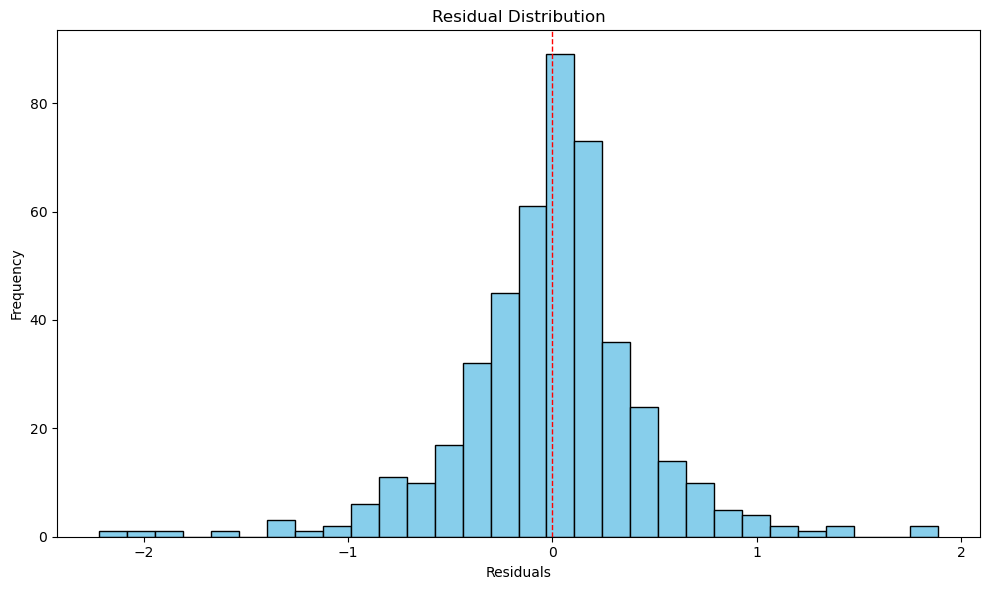

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 获取回归系数和置信区间
coefficients = fixed_effects_results.params
conf_int = fixed_effects_results.conf_int()

# 预测值和残差
predicted = fixed_effects_results.predict().fitted_values
residuals = fixed_effects_results.resids

# 残差分布直方图
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

线性可视化

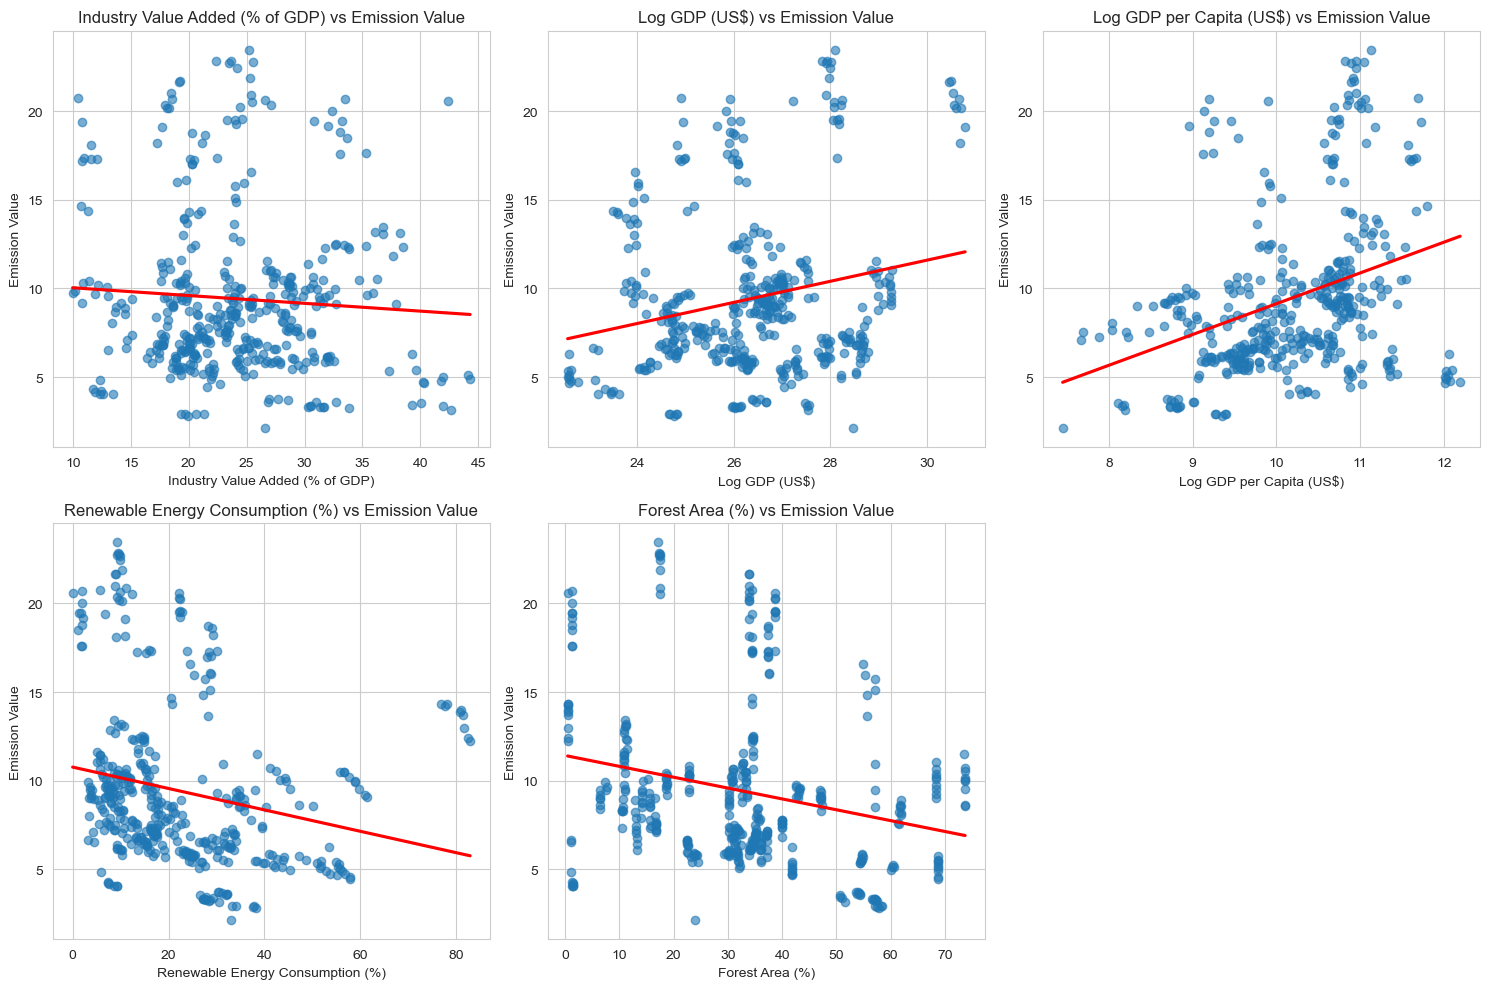

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 将多重索引还原为普通列，方便绘图
linear_data = merged_data.reset_index()

# 设置图表风格
sns.set_style("whitegrid")

# 创建多个散点图和回归拟合线
plt.figure(figsize=(15, 10))

# 遍历每个独立变量
for i, var in enumerate(independent_vars, 1):
    plt.subplot(2, 3, i)  # 2行3列的布局
    sns.regplot(
        x=linear_data[var],
        y=linear_data[dependent_var],
        scatter_kws={'alpha': 0.6},  # 调整散点透明度
        line_kws={'color': 'red'},  # 设置拟合线的颜色
        ci=None  # 不显示置信区间
    )
    plt.title(f"{var} vs {dependent_var}")
    plt.xlabel(var)
    plt.ylabel(dependent_var)

plt.tight_layout()
plt.show()


非线性可视化

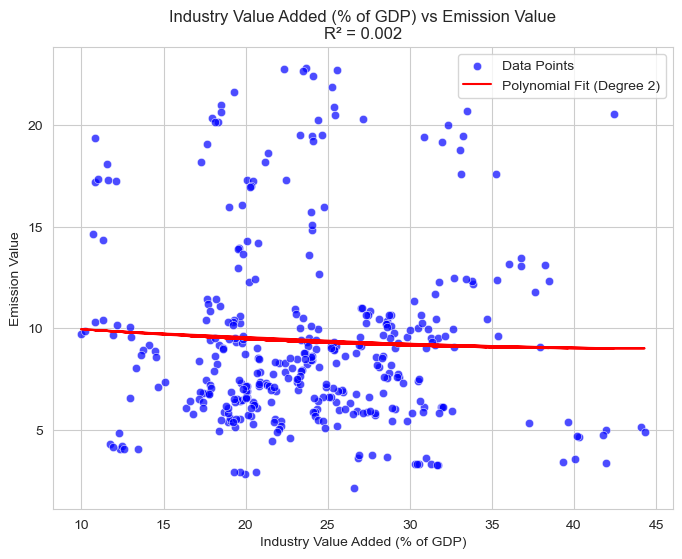

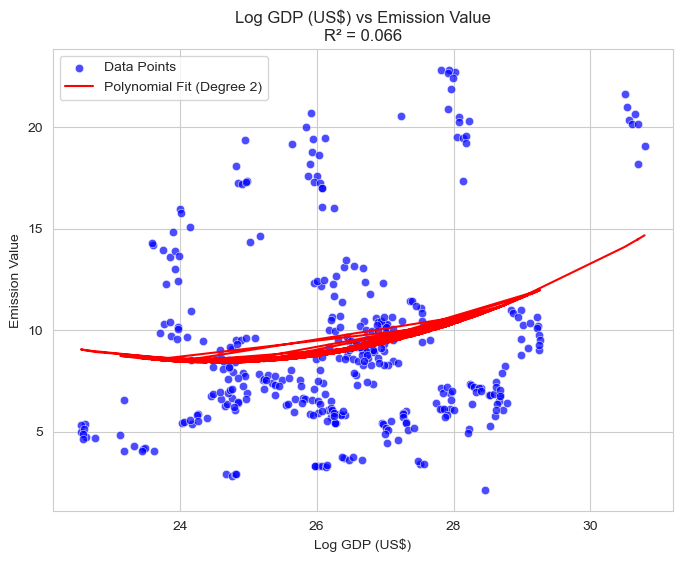

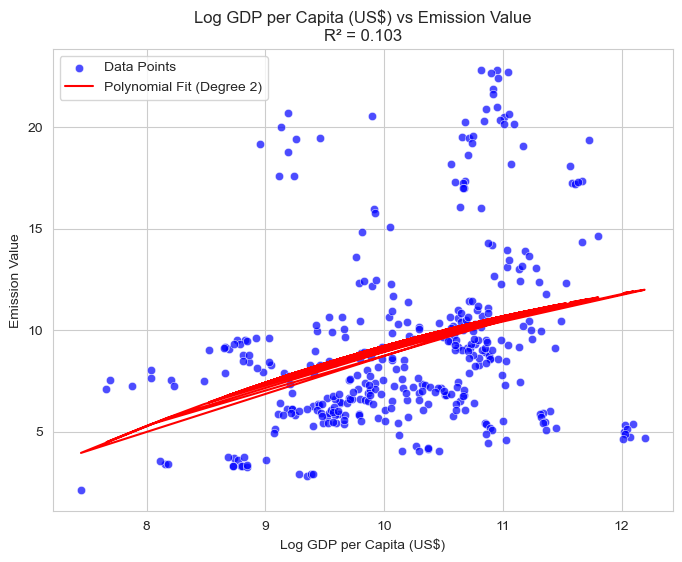

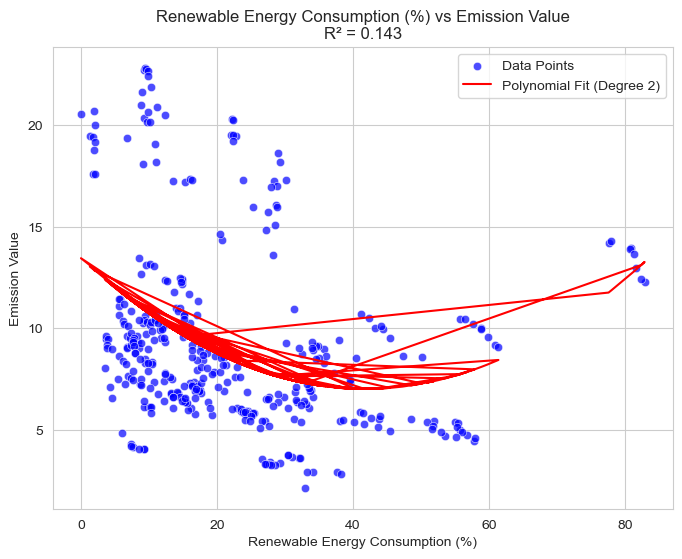

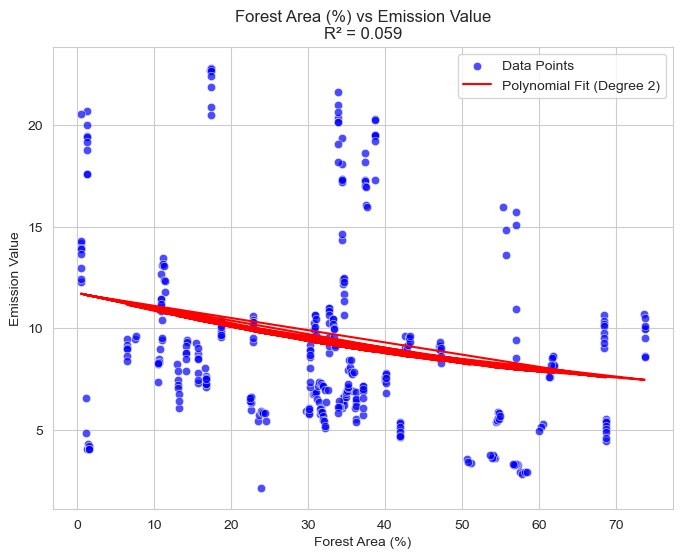

In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 定义自变量和因变量
independent_vars = [
    "Industry Value Added (% of GDP)",
    "Log GDP (US$)",
    "Log GDP per Capita (US$)",
    "Renewable Energy Consumption (%)",
    "Forest Area (%)"
]
dependent_var = "Emission Value"

# 确保数据无缺失值
data_clean = merged_data.dropna()

# 创建多项式回归模型
def polynomial_regression_and_plot(data, x_var, y_var, degree=2):
    # 准备数据
    x = data[x_var].values.reshape(-1, 1)
    y = data[y_var].values

    # 多项式特征
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x)

    # 拟合多项式回归模型
    model = LinearRegression()
    model.fit(x_poly, y)
    y_pred = model.predict(x_poly)

    # 计算R²
    r2 = r2_score(y, y_pred)

    # 可视化
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x.flatten(), y=y, color='blue', label='Data Points', alpha=0.7)
    plt.plot(x.flatten(), y_pred, color='red', label=f'Polynomial Fit (Degree {degree})')
    plt.title(f'{x_var} vs {y_var}\nR² = {r2:.3f}')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.legend()
    plt.show()

# 对每个变量进行非线性拟合和可视化
for var in independent_vars:
    polynomial_regression_and_plot(data_clean, var, dependent_var, degree=2)


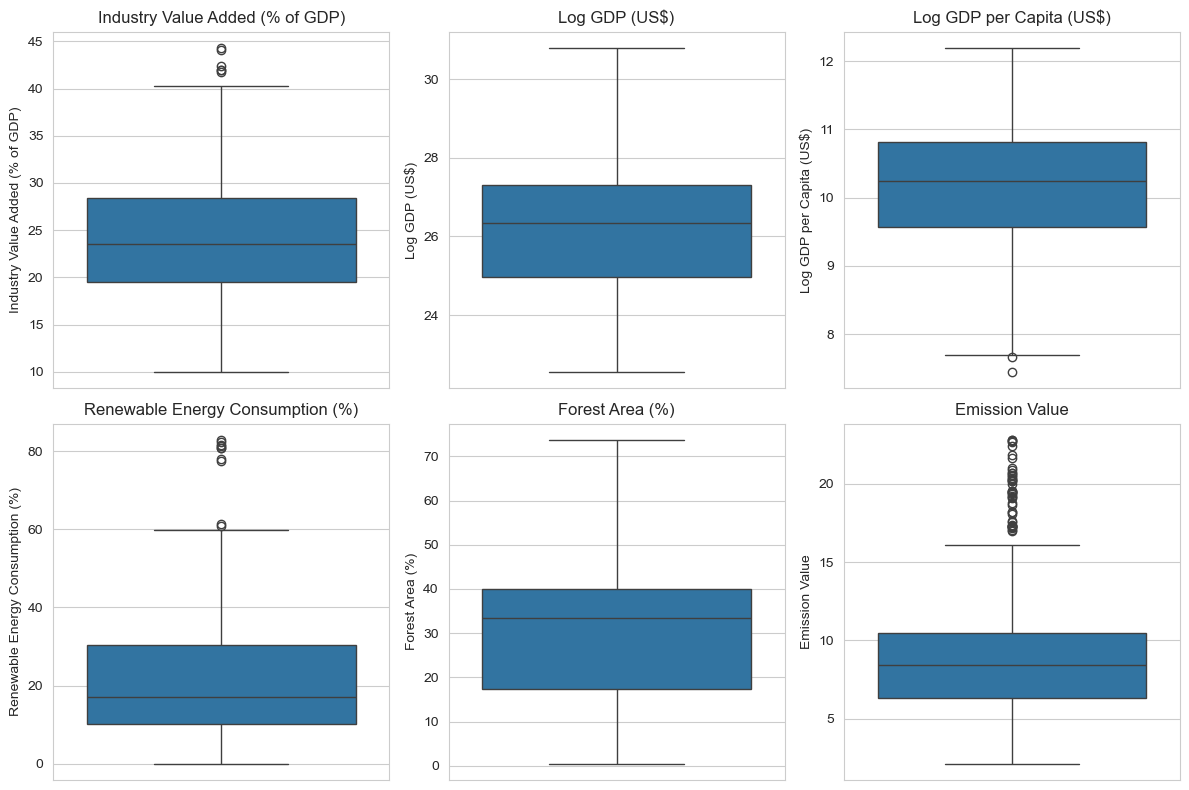

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制箱线图
plt.figure(figsize=(12, 8))
for i, var in enumerate(independent_vars + [dependent_var]):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=merged_data_clean[var])
    plt.title(var)

plt.tight_layout()
plt.show()
